In [15]:
!pip install pandas numpy==1.25.2 scikit-learn matplotlib seaborn gensim nltk tqdm
!pip uninstall scipy gensim
!pip install scipy==1.10.1
!pip install gensim==4.3.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 36.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 9.1.1 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
blis 1.0.2 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.2 which is incompatible.
jax 0.5.2 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
scikit-image 0.25.2 requires scipy>=1.11.4, but you have scipy 1.10.1 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.2 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.25.2 which is incompatible.
spacy 3.8.5 requires thinc<8.4.0,>=8.3.4, but you have t

Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/scipy-1.10.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/scipy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/scipy.libs/libopenblasp-r0-41284840.3.18.so
    /usr/local/lib/python3.11/dist-packages/scipy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/scipy/*
Proceed (Y/n)? ERROR: Operation cancelled by user
^C
^C
^C


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[==================================================] 100.0% 128.1/128.1MB downloaded


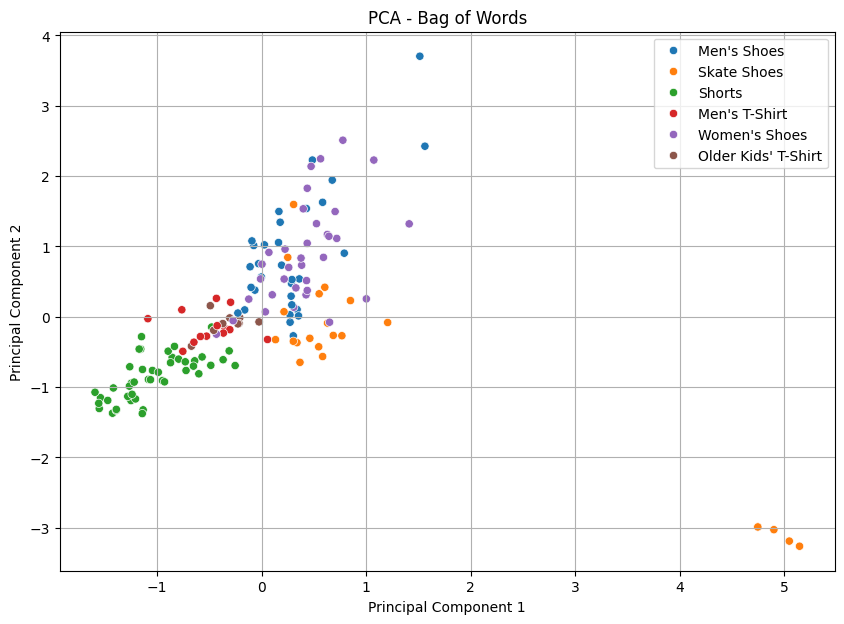

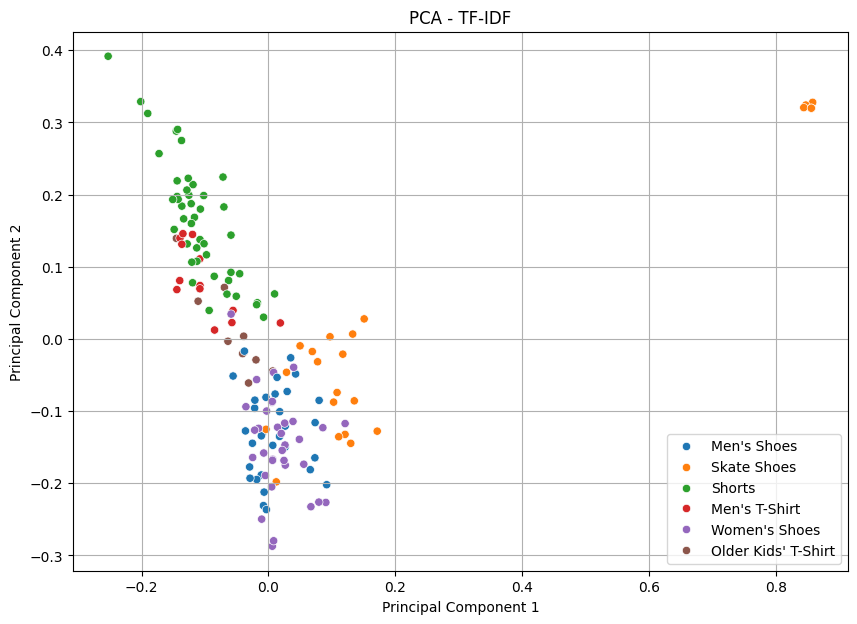

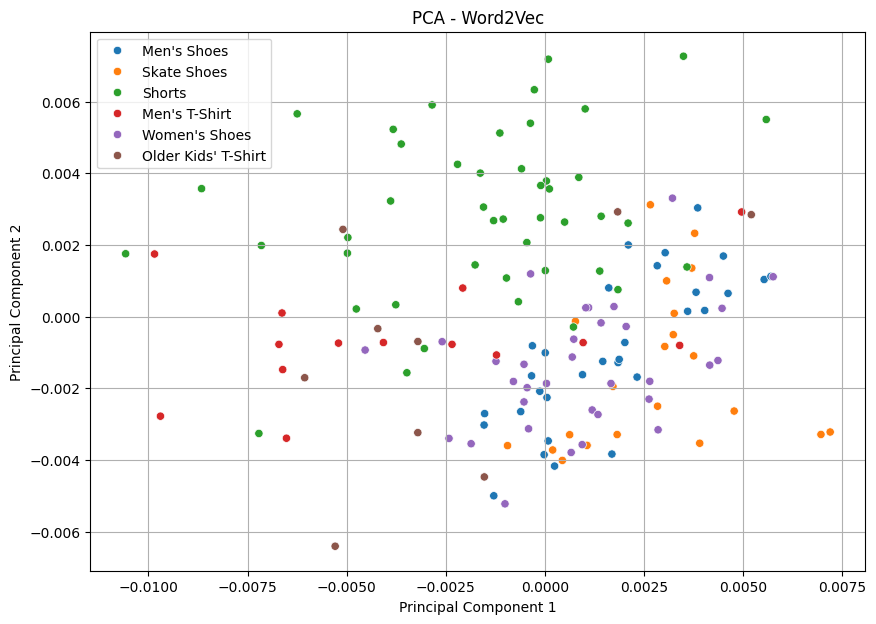

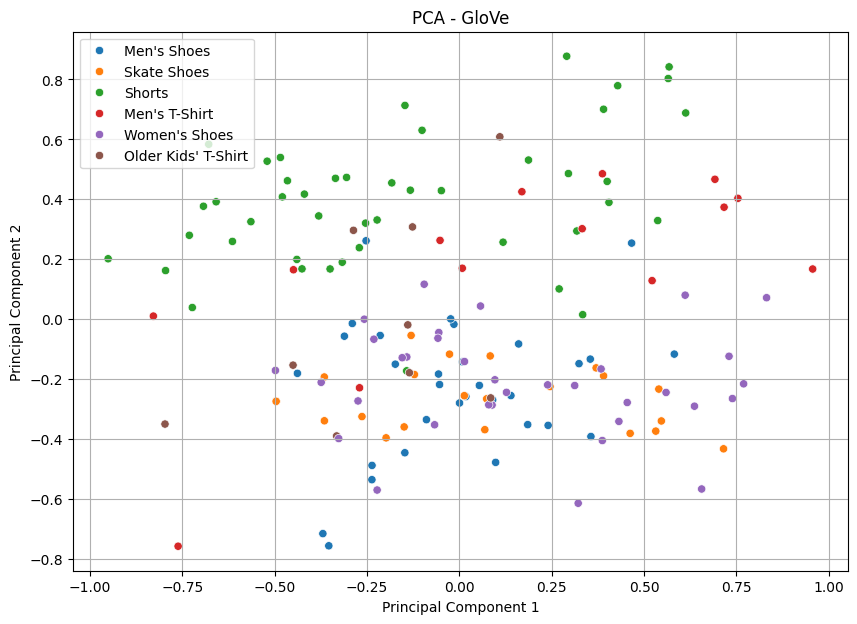

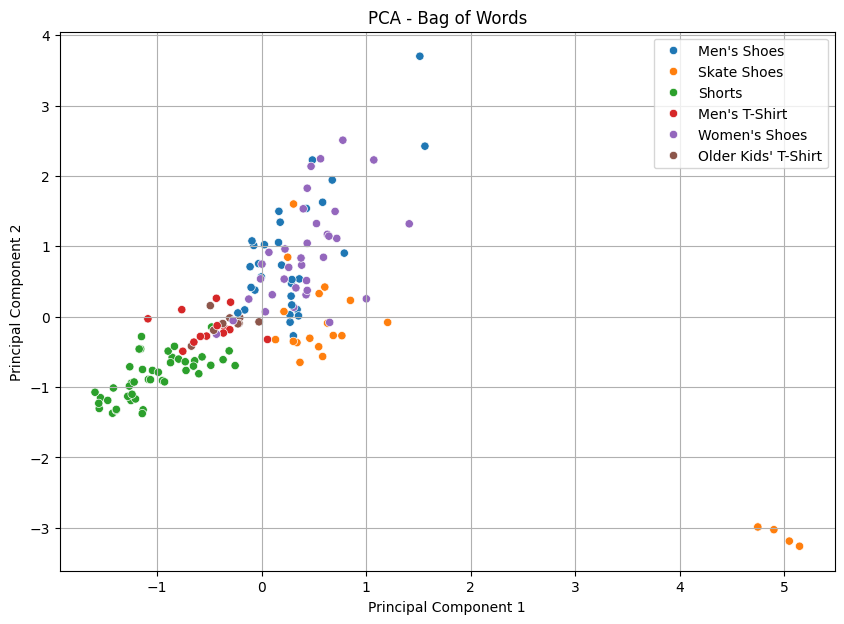

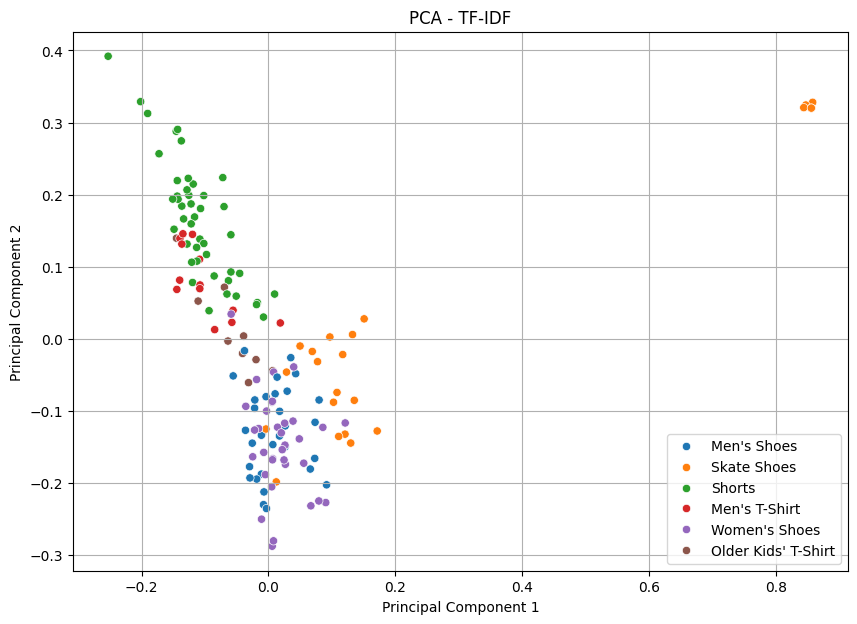

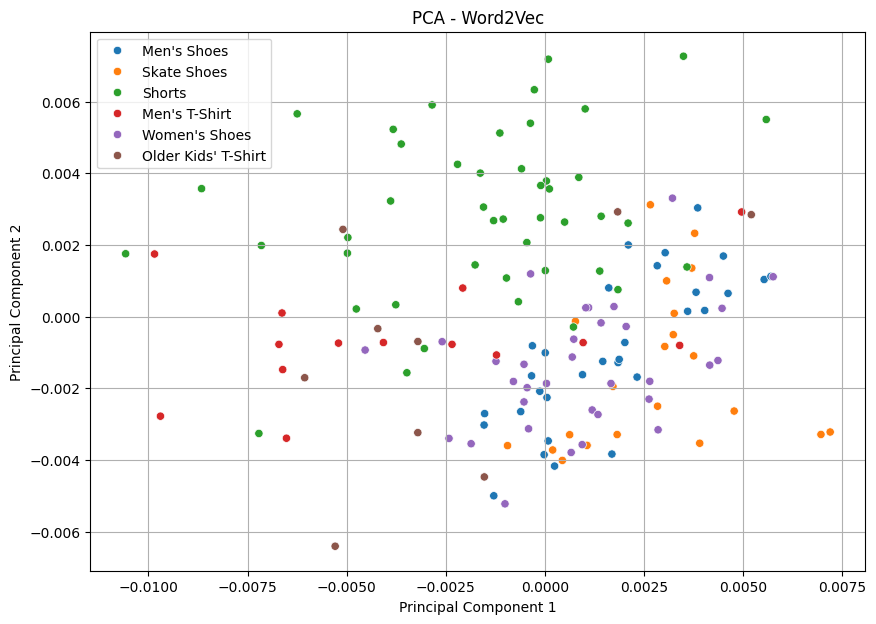

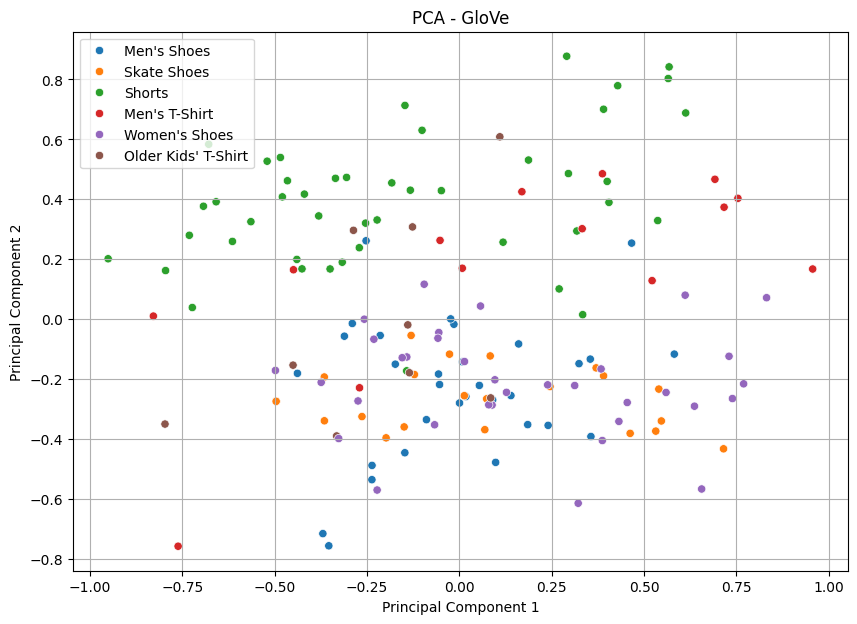

In [13]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from tqdm import tqdm
from numpy import triu

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from tqdm import tqdm
from numpy import triu

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Load dataset (update the path if needed)
df = pd.read_csv("/NikeProductDescriptions.csv")

# Filter subtitles
valid_subtitles = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]
df = df[df['Subtitle'].isin(valid_subtitles) | df['Subtitle'].str.contains('Shorts', case=False)]
df.loc[df['Subtitle'].str.contains('Shorts', case=False), 'Subtitle'] = 'Shorts'

# Text preprocessing
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words and w not in string.punctuation]
    return ' '.join(tokens)

df['Cleaned_Desc'] = df['Product Description'].apply(preprocess)
tokenized_texts = df['Cleaned_Desc'].apply(lambda x: x.split())

# Bag of Words
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df['Cleaned_Desc'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Desc'])

# Word2Vec
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
def get_w2v_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
w2v_vectors = np.vstack(tokenized_texts.apply(get_w2v_vector))

# GloVe (100-dimensional pretrained)
glove = api.load("glove-wiki-gigaword-100")
def get_glove_vector(tokens):
    vectors = [glove[w] for w in tokens if w in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
glove_vectors = np.vstack(tokenized_texts.apply(get_glove_vector))

# PCA visualization
def plot_pca(vectors, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    df_vis = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
    df_vis['Subtitle'] = df['Subtitle'].values
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='Subtitle', palette='tab10')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate all PCA plots
plot_pca(bow.toarray(), "PCA - Bag of Words")
plot_pca(tfidf.toarray(), "PCA - TF-IDF")
plot_pca(w2v_vectors, "PCA - Word2Vec")
plot_pca(glove_vectors, "PCA - GloVe")
valid_subtitles = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes",
    "Skate Shoes", "Older Kids' T-Shirt"
]
df = df[df['Subtitle'].isin(valid_subtitles) | df['Subtitle'].str.contains('Shorts', case=False)]
df.loc[df['Subtitle'].str.contains('Shorts', case=False), 'Subtitle'] = 'Shorts'

# Text preprocessing
stop_words = set(stopwords.words('english'))
def preprocess(text):
    tokens = word_tokenize(str(text).lower())
    tokens = [w for w in tokens if w.isalpha() and w not in stop_words and w not in string.punctuation]
    return ' '.join(tokens)

df['Cleaned_Desc'] = df['Product Description'].apply(preprocess)
tokenized_texts = df['Cleaned_Desc'].apply(lambda x: x.split())

# Bag of Words
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(df['Cleaned_Desc'])

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(df['Cleaned_Desc'])

# Word2Vec
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)
def get_w2v_vector(tokens):
    vectors = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
w2v_vectors = np.vstack(tokenized_texts.apply(get_w2v_vector))

# GloVe (100-dimensional pretrained)
glove = api.load("glove-wiki-gigaword-100")
def get_glove_vector(tokens):
    vectors = [glove[w] for w in tokens if w in glove]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
glove_vectors = np.vstack(tokenized_texts.apply(get_glove_vector))

# PCA visualization
def plot_pca(vectors, title):
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    df_vis = pd.DataFrame(reduced, columns=['PC1', 'PC2'])
    df_vis['Subtitle'] = df['Subtitle'].values
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=df_vis, x='PC1', y='PC2', hue='Subtitle', palette='tab10')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate all PCA plots
plot_pca(bow.toarray(), "PCA - Bag of Words")
plot_pca(tfidf.toarray(), "PCA - TF-IDF")
plot_pca(w2v_vectors, "PCA - Word2Vec")
plot_pca(glove_vectors, "PCA - GloVe")